In [1]:
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import os.path

class price:
    def __init__(self, ticker, time='max'):
        self.stock = yf.Ticker(ticker)
        self.info = self.stock.info
        #period : 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        self.price = self.stock.history(period=time)

class fundamental(price):
    def __init__(self, ticker, time='max', interval = 'year', level_of_rounding = 'million'):
        try:
            super().__init__(ticker, time)
            print("Please Wait...")
            
            if level_of_rounding == 'million':
                rounding = 1000000
            elif level_of_rounding == 'billion':
                rounding = 1000000000
            elif level_of_rounding == 'one':
                rounding = 1
            
            if interval == 'year':
                year_statement = True
            elif interval == 'quarter':
                year_statement = False
                
            #get data from Yahoo Finance
            self.balance_sheet_raw = si.get_balance_sheet(ticker,year_statement)
            self.income_statement_raw = si.get_income_statement(ticker, year_statement)
            self.cash_flow_raw = si.get_cash_flow(ticker, year_statement)
            self.valuation = si.get_stats_valuation(ticker)
            #reshaping and pivoting
            self.total_share = int(self.info['marketCap']/self.price.iloc[-1,3])/rounding
            balance_sheet = self.balance_sheet_raw.loc[['totalAssets', 'totalStockholderEquity', 'retainedEarnings', 'totalLiab']]/rounding
            balance_sheet = balance_sheet.reset_index()
            self.balance_sheet = balance_sheet.rename(columns={'Breakdown': 'Keys'})
            income_statement = self.income_statement_raw.loc[['totalRevenue', 'operatingIncome', 'netIncome']]/rounding
            income_statement = income_statement.reset_index()
            self.income_statement = income_statement.rename(columns={'Breakdown': 'Keys'})
            cash_flow = self.cash_flow_raw.loc[['totalCashflowsFromInvestingActivities', 'totalCashFromFinancingActivities', 'totalCashFromOperatingActivities']]/rounding
            cash_flow = cash_flow.reset_index()
            self.cash_flow = cash_flow.rename(columns={'Breakdown': 'Keys'})
            self.financial = self.balance_sheet.append([self.income_statement, self.cash_flow]).set_index('Keys').T
            #add ratio
            self.financial['debtEquityRatio'] = self.financial['totalLiab']/self.financial['totalStockholderEquity']
            self.financial['retainedEarningsEquityRatio'] = self.financial['retainedEarnings']/self.financial['totalStockholderEquity']
            self.financial['returnOnEquity'] = self.financial['netIncome']/self.financial['totalStockholderEquity']
            self.financial['operationalProfitMargin'] = self.financial['operatingIncome']/self.financial['totalRevenue']
            self.financial['netProfitMargin'] = self.financial['netIncome']/self.financial['totalRevenue']
            self.financial['earningPerShare'] = self.financial['netIncome']/self.total_share
            self.financial['bookValuePerShare'] = self.financial['totalStockholderEquity']/self.total_share
            print("Done")
        except:
            print('Error')
            pass

def write_csv(filename, df):
    if os.path.isfile(filename):
        df.to_csv(filename, header=False, index=False, mode='a')
    else:    
        df.to_csv(filename, header=True, index=False, mode='w')

def add_data(file, dataframe, ticker):
    dataframe['stockCode'] = ticker
    stock_columns = dataframe.columns.values.tolist()
    list_columns = [stock_columns[-1]] + stock_columns[0:-1]
    dataframe = dataframe.reindex(columns= list_columns)
    write_csv(file, dataframe)
                     
def add_stock_data(dataframe, fundamental_file, price_file, time = '5y', interval = 'year', no = 1):
    number = no - 1           
    for stock_ticker in dataframe['Kode'].iloc[number:]:
        print(number+1, 'Downloading Data :', stock_ticker)
        number += 1
        stock_data = fundamental(stock_ticker + '.JK', time, interval)
        #fundamental and price
        stock_value = stock_data.financial.T.reset_index()
        stock_price = stock_data.price.reset_index()[['Date', 'Close']]
        add_data(fundamental_file, stock_value, stock_ticker)
        add_data(price_file, stock_price, stock_ticker)

In [2]:
#read excel
# jii70 = pd.read_excel('JII70.xlsx', engine = 'openpyxl', header=0)

In [3]:
# add_stock_data(jii70, 'JII70_fundamental_quarter.csv', 'JII70_price_quarter.csv', time='1y', interval='quarter')

In [2]:
data_stock = pd.read_csv('JII70_fundamental.csv')
data_price = pd.read_csv('JII70_price.csv')
stock = data_stock.loc[data_stock['stockCode'] == 'AALI']
price = data_price.loc[data_price['stockCode'] == 'AALI']

In [85]:
import datetime
price.loc[:,'Date'] = price['Date'].astype('datetime64[ns]')
price1 = price[price['Date'].dt.year == '2016']
price1['per'] = price['Close']/
price1['pbv'] = price['Close']/


price2 = price
# price2 = price

In [3]:
stock = stock.drop(columns = 'stockCode').T
stock.columns = stock.iloc[0]
stock = stock.drop('Keys')
stock = stock.set_index([pd.Index([2019, 2018, 2017, 2016])])
stock = stock.iloc[::-1]
stock = stock.reset_index()
stock = stock.rename(columns = {'index': 'Year'})
stock

Keys,Year,totalAssets,totalStockholderEquity,retainedEarnings,totalLiab,totalRevenue,operatingIncome,netIncome,totalCashflowsFromInvestingActivities,totalCashFromFinancingActivities,totalCashFromOperatingActivities,debtEquityRatio,retainedEarningsEquityRatio,returnOnEquity,operationalProfitMargin,netProfitMargin,earningPerShare,bookValuePerShare
0,2016,2.42261e+07,1.71353e+07,1.22939e+07,6.63264e+06,1.41214e+07,2.65861e+06,2.00697e+06,-2.39541e+06,116463,2.51182e+06,0.387075,0.717464,0.117125,0.188268,0.142123,1042.75,8902.88
1,2017,2.51196e+07,1.82358e+07,1.34279e+07,6.40713e+06,1.73057e+07,3.0509e+06,1.96803e+06,-1.7535e+06,-1.36162e+06,2.84182e+06,0.351349,0.736349,0.107921,0.176295,0.113721,1022.52,9474.67
2,2018,2.6857e+07,1.89896e+07,1.41817e+07,7.38244e+06,1.90844e+07,2.32591e+06,1.43851e+06,-1.67877e+06,-609332,2.04524e+06,0.388762,0.746815,0.0757525,0.121875,0.0753763,747.399,9866.33
3,2019,2.69741e+07,1.85212e+07,1.38439e+07,7.9956e+06,1.74527e+07,960308,211117,-1.30738e+06,334094,1.29235e+06,0.431701,0.747463,0.0113987,0.0550233,0.0120965,109.689,9622.93


<BarContainer object of 4 artists>

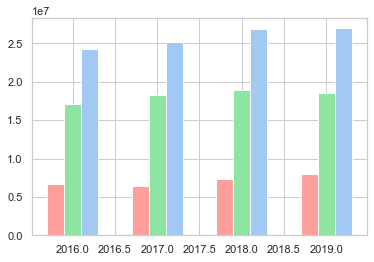

In [74]:
import matplotlib.pyplot as plt



plt.bar(stock['Year']+0.2, stock['totalAssets'], width=0.2, color='b', label='Asset')
plt.bar(stock['Year'], stock['totalStockholderEquity'], width=0.2, color='g', label='Equity')
plt.bar(stock['Year']-0.2, stock['totalLiab'], width=0.2, color='r', label='Liabilities')


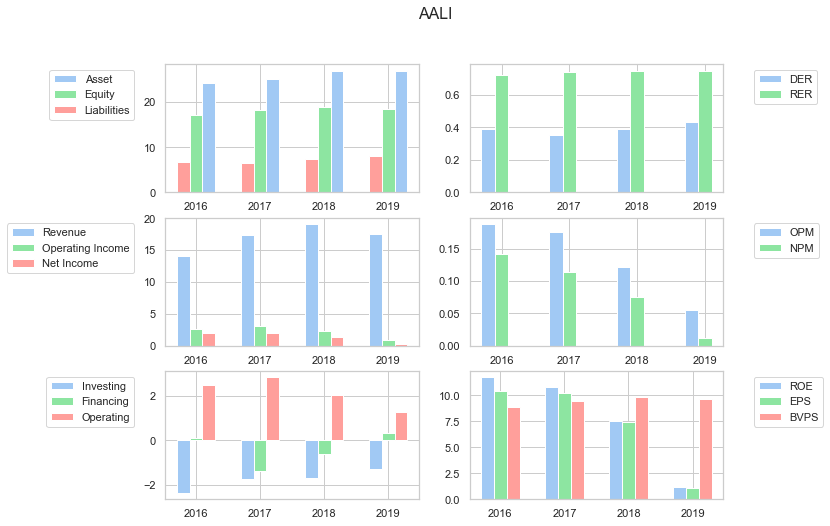

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
fig = plt.figure(figsize = (10,8))
fig.suptitle('AALI', fontsize=16)
rounding = 1000000

plt.subplot(3, 2, 1)
plt.bar(stock['Year']+0.2, stock['totalAssets']/rounding, width=0.2, color='b', label='Asset')
plt.bar(stock['Year'], stock['totalStockholderEquity']/rounding, width=0.2, color='g', label='Equity')
plt.bar(stock['Year']-0.2, stock['totalLiab']/rounding, width=0.2, color='r', label='Liabilities')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(-0.1, 1), loc = 'upper right')

plt.subplot(3, 2, 3)
plt.bar(stock['Year']-0.2, stock['totalRevenue']/rounding, width=0.2, color='b', label='Revenue')
plt.bar(stock['Year'], stock['operatingIncome']/rounding, width=0.2, color='g', label='Operating Income')
plt.bar(stock['Year']+0.2, stock['netIncome']/rounding, width=0.2, color='r', label='Net Income')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(-0.1, 1), loc = 'upper right')

plt.subplot(3, 2, 5)
plt.bar(stock['Year']-0.2, stock['totalCashflowsFromInvestingActivities']/rounding, width=0.2, color='b', label='Investing')
plt.bar(stock['Year'], stock['totalCashFromFinancingActivities']/rounding, width=0.2, color='g', label='Financing')
plt.bar(stock['Year']+0.2, stock['totalCashFromOperatingActivities']/rounding, width=0.2, color='r', label='Operating')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(-0.1, 1), loc = 'upper right')

plt.subplot(3, 2, 2)
plt.bar(stock['Year']-0.2, stock['debtEquityRatio'], width=0.2, color='b', label='DER')
plt.bar(stock['Year'], stock['retainedEarningsEquityRatio'], width=0.2, color='g', label='RER')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

plt.subplot(3, 2, 4)
plt.bar(stock['Year']-0.2, stock['operationalProfitMargin'], width=0.2, color='b', label='OPM')
plt.bar(stock['Year'], stock['netProfitMargin'], width=0.2, color='g', label='NPM')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

plt.subplot(3, 2, 6)
plt.bar(stock['Year']-0.2, stock['returnOnEquity']*100, width=0.2, color='b', label='ROE')
plt.bar(stock['Year'], stock['earningPerShare']/100, width=0.2, color='g', label='EPS')
plt.bar(stock['Year']+0.2, stock['bookValuePerShare']/1000, width=0.2, color='r', label='BVPS')
plt.xticks([2019, 2018, 2017, 2016])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

plt.show()